# Potentials

GRANAD lets you specify coupling to external light using (an arbitrary combination of) electromagnetic potentials. You do this by modifying GRANAD's internal representation of the Hamiltonian, which is a dictionary.

## Background

Consider GRANAD's master equation 

$$\dot{\rho}(t) = -i [H[t,\rho(t)], \rho] + \mathcal{D}[t, \rho]$$

By default, GRANAD simulates the following dipole-gauge expression for the Hamiltonian including an external electric field $\vec{E}$

$$H[t,\rho(t)] = h^{0} + \vec{E} \vec{P} + C(\rho(t) - \rho^{0})$$

where

1. $h^{0}$ is the unperturbed or bare Hamiltonian constructed from localized orbitals.
2. $\vec{P}$ is the polarization operator depending on space $\vec{r}$ and transition dipole moments $\vec{d}$, leading to an interatomic potential $\vec{E}\vec{r}$ and an intra-atomic potential $\vec{E} \vec{d}$.
3. $\rho^{0}$ is the stationary density matrix of the system's ground state, and $C$ is the Coulomb matrix (a subset of two-body matrix elements).

You can modify GRANAD's internal representation of the Hamiltonian to include your own potential terms. Here, you have two options:

1. Define potentials on your own.
2. Use built-in potentials.

The first solution is more flexible, but a bit more complicated, so we will focus on the built-in potentials in this tutorial.

## Built-in Potentials

First, we set up a small triangle.

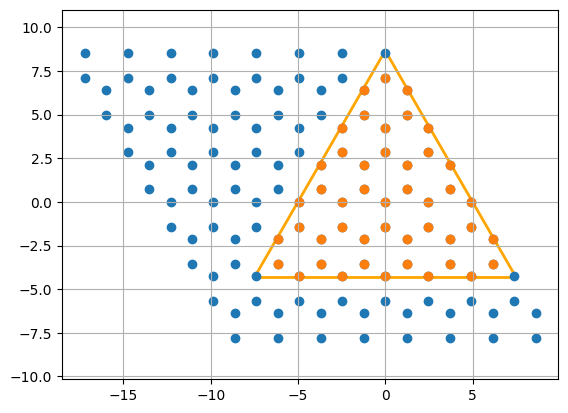

In [1]:
from granad import MaterialCatalog, Triangle
flake = MaterialCatalog.get( "graphene" ).cut_flake( Triangle(15), plot = True  )

If we call `flake.master_equation`, the arguments we passed in (e.g., the illumination) are turned into a representation of the Hamiltonian. By default, this representation corresponds to the dipole-gauge model discussed above.

This representation will be passed to "lower-level" simulation functions. These functions will turn it into arrays and integrate it.

We can directly look at this representation.

In [2]:
hamiltonian_model = flake.get_hamiltonian()
print(hamiltonian_model)

{'bare_hamiltonian': <function BareHamiltonian.<locals>.<lambda> at 0x7fe4948ebf60>, 'coulomb': <function Coulomb.<locals>.<lambda> at 0x7fe4948ebe20>}


We see that it is a dictionary. The keys are strings, the values are functions. Each function is a term in the Hamiltonian, identified by the keys

In [3]:
print(hamiltonian_model.keys())

dict_keys(['bare_hamiltonian', 'coulomb'])


So, as we said, we have a bare Hamiltonian, and an induced Coulomb interaction. But where is the dipole gauge coupling? Remember that we did not pass in any external illumination, so GRANAD assumes there is none. This can be changed as follows

In [4]:
from granad import Wave
wave = Wave( amplitudes = [1.0, 0., 0.], frequency = 1.0 )
hamiltonian_model_external_illu = flake.get_hamiltonian( illumination = wave )
print(hamiltonian_model_external_illu.keys())

dict_keys(['bare_hamiltonian', 'coulomb', 'potential'])


We add our own potentials to the Hamiltonian by adding entries to the dictionary, like `hamiltonian_model["my_potential"] = my_potential`. 

In choosing `my_potential`, you have several options, documented in the API. For demonstration, we will model a dipole pulse

In [5]:
from granad import potentials
dip_pulse = potentials.DipolePulse( dipole_moment = [1., 0., 0.],
                                    source_location = [0., 0., 1.],
                                    omega = 3,
                                    sigma = 1,
                                    t0 = 3)

We can visualize its impact at any time t. The potential is a function and returns a diagonal matrix in site basis. The arguments to this function will be explained in the tutorial on custom master equations.

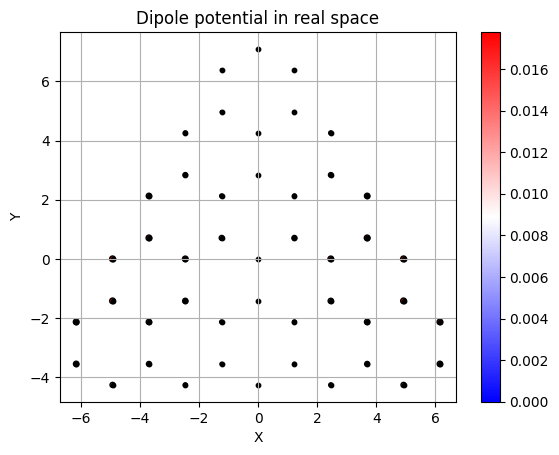

In [6]:
import jax.numpy as jnp
time = 1.0
flake.show_2d( display = jnp.abs(dip_pulse(time,
                                           0, # this argument will be explained in another tutorial, you can always pass in 0
                                           flake.get_args() # this argument will be explained in another tutorial, you can always copy this
                                           ).diagonal()),
               title = "Dipole potential in real space"
              )

We can now include it in the Hamiltonian

In [7]:
hamiltonian_model["dipole_pulse"] = dip_pulse

To simulate this Hamiltonian instead of the default one, we have to pass it explicitly to the time-domain simulation function

RHS compiled
RHS compiled


100.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


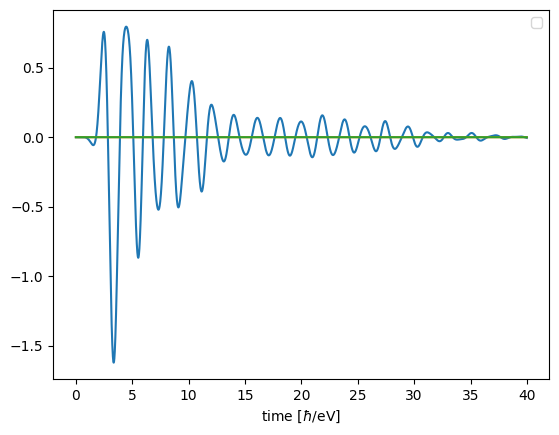

In [8]:
import diffrax
result = flake.master_equation( end_time = 40.0,
                                hamiltonian = hamiltonian_model,
                                expectation_values = [flake.dipole_operator],
                                relaxation_rate = 1/10,
                                solver = diffrax.Dopri8() # high accuracy explicit solver to avoid oscillating tails
                               )
flake.show_res( result )

You can simulate any number of dipoles (or terms) by adding more keys to the dictionary. **Just name them differently, e.g., "dipole_1", "dipole_2", to make sure they don't get overwritten.**

Note: The dipole potential above is purely diagonal, i.e. it will miss the intra-atomic dipolar contribution between orbitals $i$ and $j$ connected by a transition dipole moment $\vec{d}_{ij}$.
In dipole gauge, this term is expressed as $\vec{E} \vec{d}_{ij}$. If you want to include this term explicitly, add another potential to the Hamiltonian.
To do so, define a function evaluating the electric field of your dipole at the positions of the orbitals like so `dipole_electric_field : time -> 3xN-Array`.

You can use the built-in dipole gauge like `potentials.DipoleGauge( illumination = dipole_electric_field, intra_only = True )`.

If you place the dipole at the position of an orbital, the potential is set to zero there.

**Warning: We did not need the illumination argument and so the `result` object contains no information on it. It is populated with zeroes by default**

In [9]:
print(result.td_illumination)

[[0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]]


You can still supply an illumination function, which will be used as the attribute.